# Adult Dataset

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder

In [2]:
plt.rcParams['figure.figsize'] = [4, 3]

In [3]:
import warnings

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    df = pd.read_excel('data/existing-customers.xlsx')

In [4]:
df.shape

(32561, 15)

In [5]:
df.head()

,RowID,age,workclass,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,class
0,Row0,39,State-gov,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,Row1,50,Self-emp-not-inc,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,Row2,38,Private,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,Row3,53,Private,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,Row4,28,Private,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   RowID           32561 non-null  object
 1   age             32561 non-null  int64 
 2   workclass       30725 non-null  object
 3   education       32561 non-null  object
 4   education-num   32561 non-null  int64 
 5   marital-status  32561 non-null  object
 6   occupation      30718 non-null  object
 7   relationship    32561 non-null  object
 8   race            32561 non-null  object
 9   sex             32561 non-null  object
 10  capital-gain    32561 non-null  int64 
 11  capital-loss    32561 non-null  int64 
 12  hours-per-week  32561 non-null  int64 
 13  native-country  31978 non-null  object
 14  class           32561 non-null  object
dtypes: int64(5), object(10)
memory usage: 3.7+ MB


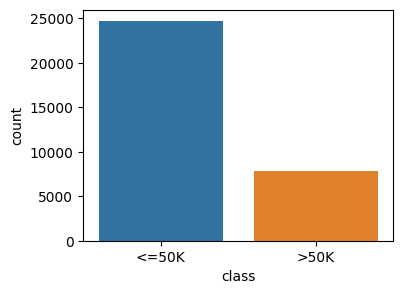

In [7]:
sns.countplot(df, x='class');

### Convert Target Attribute

### Handle Redundant Attributes

- `RowID` does not provide any information
- `education` is equivalent to `education-num`

In [8]:
df2 = df.copy()

df2['class'] = df2['class'].replace({'<=50K': 0, '>50K': 1})

df2.drop(['RowID'], axis=1, inplace=True)
df2.drop(['education'], axis=1, inplace=True)

df2.head()

,age,workclass,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,class
0,39,State-gov,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,0
1,50,Self-emp-not-inc,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,0
2,38,Private,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,0
3,53,Private,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,0
4,28,Private,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,0


### Handle Missing Values

- `workclass` - impute with most frequent value
- `native-country` - impute with most frequent value
- `occupation` - fill based on frequency to avoid bias

In [9]:
df2.isnull().sum()

age                  0
workclass         1836
education-num        0
marital-status       0
occupation        1843
relationship         0
race                 0
sex                  0
capital-gain         0
capital-loss         0
hours-per-week       0
native-country     583
class                0
dtype: int64

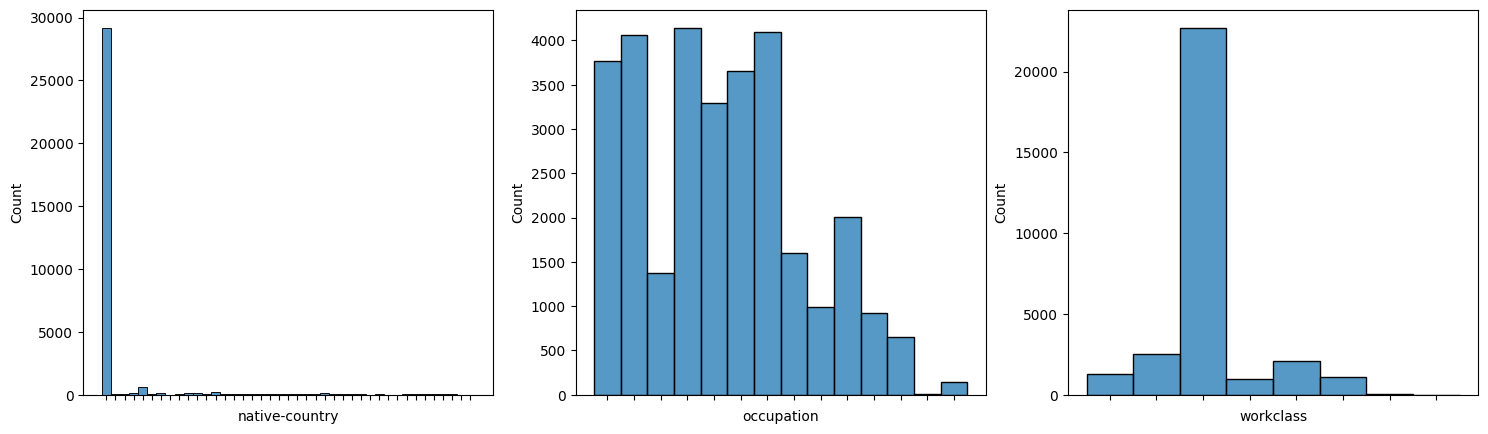

In [10]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18,5))
axes[0].set_xticklabels([])
axes[1].set_xticklabels([])
axes[2].set_xticklabels([])
sns.histplot(df2, ax=axes[0], x="native-country")
sns.histplot(df2, ax=axes[1], x="occupation")
sns.histplot(df2, ax=axes[2], x="workclass");

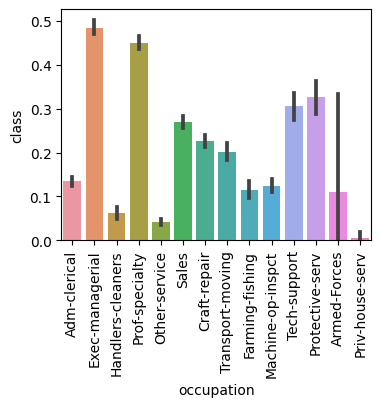

In [11]:
plt.xticks(rotation=90)
sns.barplot(x='occupation', y='class', data=df2);

In [16]:
df3 = df2.copy()

simple_imputer = SimpleImputer(strategy='most_frequent')

df3['workclass'] = simple_imputer.fit_transform(df3[['workclass']])
df3['native-country'] = simple_imputer.fit_transform(df3[['native-country']])

freqs = df['occupation'].value_counts(normalize=True)
missing = df['occupation'].isnull()
n_missing = missing.sum()
fill_values = np.random.choice(freqs.index, size=n_missing, p=freqs.values)
df3.loc[missing, 'occupation'] = fill_values

df3.head()

,age,workclass,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,class
0,39,State-gov,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,0
1,50,Self-emp-not-inc,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,0
2,38,Private,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,0
3,53,Private,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,0
4,28,Private,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,0


In [17]:
df3.isnull().sum()

age               0
workclass         0
education-num     0
marital-status    0
occupation        0
relationship      0
race              0
sex               0
capital-gain      0
capital-loss      0
hours-per-week    0
native-country    0
class             0
dtype: int64

### Converting Features

- Handle attribute cardinality

In [22]:
categorical_cols = [
    'workclass',
    'marital-status',
    'occupation',
    'relationship',
    'race',
    'sex'
]

lim_categorical_cols = [
    'native-country'
]

df4 = df3.copy()

encoder = OneHotEncoder(handle_unknown='error', sparse_output=False)
encoded_cols = encoder.fit_transform(df4[categorical_cols])
encoded_df = pd.DataFrame(encoded_cols, columns=encoder.get_feature_names_out(categorical_cols))

lim_encoder = OneHotEncoder(handle_unknown='error', sparse_output=False, max_categories=3)
lim_encoded_cols = lim_encoder.fit_transform(df4[lim_categorical_cols])
lim_encoded_df = pd.DataFrame(lim_encoded_cols, columns=lim_encoder.get_feature_names_out(lim_categorical_cols))

df4 = df4.drop(categorical_cols, axis=1)
df4 = df4.drop(lim_categorical_cols, axis=1)

df4 = pd.concat([df4, encoded_df, lim_encoded_df], axis=1)

df4.head()

,age,education-num,capital-gain,capital-loss,hours-per-week,class,workclass_Federal-gov,workclass_Local-gov,workclass_Never-worked,workclass_Private,...,race_Amer-Indian-Eskimo,race_Asian-Pac-Islander,race_Black,race_Other,race_White,sex_Female,sex_Male,native-country_Mexico,native-country_United-States,native-country_infrequent_sklearn
0,39,13,2174,0,40,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
1,50,13,0,0,13,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
2,38,9,0,0,40,0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
3,53,7,0,0,40,0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
4,28,13,0,0,40,0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0


### Machine Learning

In [23]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

In [24]:
X = df4.drop(['class'], axis=1)
y = df4['class']

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.2, 
                                                    random_state=42)

In [25]:
gaussian = GaussianNB()
gaussian.fit(X_train, y_train) 

y_pred = gaussian.predict(X_test)
accuracy = accuracy_score(y_pred, y_test)
print("Accuracy: {:.2%}".format(accuracy))

Accuracy: 79.27%


In [30]:
# Define the range of values for the max_depth hyperparameter
params = {'max_depth': [2, 4, 6, 8, 10, 12, 14, 16, 18, 20]}

# Create a decision tree classifier object
decision_tree = DecisionTreeClassifier()

# Use grid search to find the best value for max_depth
grid_search = GridSearchCV(estimator=decision_tree, param_grid=params, cv=5)
grid_search.fit(X_train, y_train)

# Get the best value for max_depth and use it to create the final model
best_max_depth = grid_search.best_params_['max_depth']
final_model = DecisionTreeClassifier(max_depth=best_max_depth)
final_model.fit(X_train, y_train)

print('Best max depth: {}'.format(best_max_depth))

Best max depth: 10


In [31]:
decision_tree = DecisionTreeClassifier(max_depth=10)
decision_tree.fit(X_train, y_train)

y_pred = decision_tree.predict(X_test)
accuracy = accuracy_score(y_pred, y_test)
print("Accuracy: {:.2%}".format(accuracy))

Accuracy: 85.77%


In [32]:
from sklearn.tree import export_graphviz
import graphviz

dot_data = export_graphviz(decision_tree, out_file=None,
                           feature_names=X_train.columns,
                           class_names=['0', '1'],
                           filled=True, rounded=True,
                           special_characters=True)

graph = graphviz.Source(dot_data, format="svg")
graph.render("decision_tree")

'decision_tree.svg'